In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class SobelFilter:
    def filter_v(self, img):
        ksize = 3
        pad = ksize // 2
        K = np.array([ [1, 2, 1], [0, 0, 0], [-1, -2, -1] ], dtype=np.float32)

        H, W = img.shape
        input_image = np.pad(img, (1, 1), 'edge').astype(np.float32)
        output_image = input_image.copy()
        for i in range(H):
            for j in range(W):
                output_image[pad+i, pad+j] = np.mean(K * input_image[i:i+ksize, j:j+ksize])
        output_image = output_image[pad:pad+H, pad:pad+W]
        return output_image
    
    def filter_h(self, img):
        ksize = 3
        pad = ksize // 2
        K = np.array([ [1, 0, -1], [2, 0, -2], [1, 0, -1] ], dtype=np.float32)

        H, W = img.shape
        input_image = np.pad(img, (1, 1), 'edge').astype(np.float32)
        output_image = input_image.copy()
        for i in range(H):
            for j in range(W):
                output_image[pad+i, pad+j] = np.mean(K * input_image[i:i+ksize, j:j+ksize])
        output_image = output_image[pad:pad+H, pad:pad+W]
        return output_image

In [29]:
class GaussianFilter:
    def apply(self, img, ksize=3, sigma=3):
        gaussian_filter = np.zeros((ksize, ksize), dtype=np.float32)
        khalf = (ksize - 1) // 2
        for i in range(ksize):
            for j in range(ksize):
                y = i - khalf
                x = j - khalf
                a = -(y*y+x*x)/(2*(sigma**2))
                gaussian_filter[i, j] = 1/(2*np.pi*(sigma**2)) * np.exp(a)
        gaussian_filter /= np.sum(gaussian_filter)
        
        input_img = np.pad(img, (khalf, khalf), "edge")
        output_img = np.zeros_like(img, dtype=np.float32)
        H, W = img.shape[:2]
        for i in range(H):
            for j in range(W):
                output_img[i, j] = np.sum(input_img[i:i+ksize, j:j+ksize] * gaussian_filter)
        return output_img

In [21]:
class HessianMatrix:
    def __init__(self, Ix, Iy):
        self.mat_dict = {}
        self.mat_dict["Ix"] = Ix
        self.mat_dict["Iy"] = Iy
        self.mat_dict["Ix2"] = Ix**2
        self.mat_dict["Iy2"] = Iy**2
        self.mat_dict["Ixy"] = Ix*Iy
        
    def get_matrix(self, y, x):
        return [
            [ self.mat_dict["Ix2"][y, x], self.mat_dict["Ixy"][y, x] ],
            [ self.mat_dict["Ixy"][y, x], self.mat_dict["Iy2"][y, x] ]
        ]
    
    def determinant(self):
        return self.mat_dict["Ix2"]*self.mat_dict["Iy2"] - self.mat_dict["Ixy"]**2
    
    def trace(self):
        return self.mat_dict["Ix2"] + self.mat_dict["Iy2"]
    
    def apply_filter(self, mat_name, filter_func, **kwargs):
        self.mat_dict[mat_name] = filter_func(self.mat_dict[mat_name], **kwargs)
        
    def __getitem__(self, mat_name):
        return self.mat_dict[mat_name]

In [8]:
class CornerDetection:
    def __init__(self):
        self.sobel = SobelFilter()
        self.gaussian = GaussianFilter()
    
    def hessian(self, img):
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        H, W = img_gray.shape
        Ix = self.sobel.filter_h(img_gray).astype(np.float32)
        Iy = self.sobel.filter_v(img_gray).astype(np.float32)
        hessian_mat = HessianMatrix(Ix, Iy)
        det = np.pad(hessian_mat.determinant(), 1)
        max_det = det.max()
        
        output_img = np.array((img_gray, img_gray, img_gray), dtype=np.uint8)
        output_img = np.transpose(output_img, (1, 2, 0))
        mask = np.zeros((H, W), dtype=np.uint8)
        for y in range(H):
            for x in range(W):
                max_value = det[y:y+3, x:x+3].max()
                if det[y+1, x+1] == max_value and det[y+1, x+1] > max_det * 0.1:
                    output_img[y, x] = [0, 0, 255]  # red
                    mask[y, x] = 255
        return output_img, mask
    
    def harris_part1(self, img, k_gaussian=3, sigma=3, k_harris=0.04, th=0.1):
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        H, W = img_gray.shape
        Ix = self.sobel.filter_h(img_gray).astype(np.float32)
        Iy = self.sobel.filter_v(img_gray).astype(np.float32)
        hessian_mat = HessianMatrix(Ix, Iy)
        hessian_mat.apply_filter("Ix2", self.gaussian.apply, ksize=k_gaussian, sigma=sigma)
        hessian_mat.apply_filter("Iy2", self.gaussian.apply, ksize=k_gaussian, sigma=sigma)
        hessian_mat.apply_filter("Ixy", self.gaussian.apply, ksize=k_gaussian, sigma=sigma)
        det = hessian_mat.determinant()
        tra = hessian_mat.trace()
        R = det - k_harris * (tra**2)
        return hessian_mat, R

In [27]:
class Solver:
    def __init__(self):
        self.cd = CornerDetection()
        
    def problem_81(self, img):
        output_img, mask = self.cd.hessian(img)
        plt.subplot(1, 2, 1)
        plt.imshow(output_img)
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap="gray")
        plt.show()
        
    def problem_82(self, img, k_gaussian=3, sigma=3, k_harris=0.04, th=0.1):
        hessian_mat, _ = self.cd.harris_part1(img, k_gaussian, sigma, k_harris, th)
        mat_names = ["Ix2", "Iy2", "Ixy"]
        plt.figure(figsize=(10, 5))
        for k, v in enumerate(mat_names):
            plt.subplot(1, 3, k+1)
            plt.imshow(np.clip(hessian_mat[v], 0, 255).astype(np.uint8), cmap="gray")
            plt.title(v)
        plt.show()

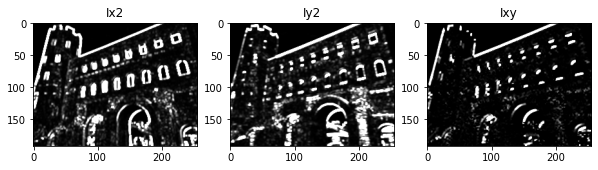

In [30]:
input_img = cv2.imread("../thorino.jpg")
solver = Solver()
solver.problem_82(input_img, k_gaussian=3, sigma=3, k_harris=0.04, th=0.1)